In [27]:
%%writefile ssm_layer.py
import torch 
from torch import nn
import numpy as np
from torch_scan import torch_scan

class SSM(nn.Module):
    """Defines a SSM layer
       x̄(t) = Ax(t) + Bu(t) -> Change in x(t) over time
       y(t) = Cx(t) + Du(t) -> We assume D=0 in this implementation

    Args:
        
        N : size of the parameter matrices

        The elements of each matrix are drawn from a uniform distribution between 0 and 1. 
    """
    
    def __init__(self, A, B, C):
        super().__init__()
        self.A = A
        self.B = B
        self.C = C

    def discretize_signal(self, A, B, C, step):
        """

        > To be applied on a discrete input sequence (u0, u1, ...) instead of continuous function
        ut), the SSM must be discretized by a step size 'd' that represents the resolution of the
        input. 

        > Conceptually, the inputs Uk can be viewed as sampling an implicit underlying
        continuous signal u(t), where uk = u(kA).

        > To discretize the continuous-time SSM, we use the bilinear method, which converts the
        state matrix A into an approximation A. The discrete SSM is:

            Ab = (I - d/2 * A)^-1 @ (I + d/2 * A)
            Bb = (I - d/2 * A)^-1 @ (dB)
            C remains the same

        """
        I = torch.eye(A.shape[0])
        BL = torch.linalg.inv(I - (step / 2.0) * A)
        BL2 = (I + (step / 2) * A)
        Ab = BL @ BL2
        Bb = (BL * step) @ B
        return Ab, Bb, C
    
    def scan_SSM(self, Ab, Bb, Cb, u, x0):
        if isinstance(Ab, np.ndarray):
            Ab = torch.tensor(Ab, dtype=torch.float32)
        if isinstance(Bb, np.ndarray):
            Bb = torch.tensor(Bb, dtype=torch.float32)
        if isinstance(Cb, np.ndarray):
            Cb = torch.tensor(Cb, dtype=torch.float32)
        if isinstance(u, np.ndarray):
            u = torch.tensor(u, dtype=torch.float32)
        if isinstance(x0, np.ndarray):
            x0 = torch.tensor(x0, dtype=torch.float32)

        def step(x_k_1, u_k):
            x_k = Ab @ x_k_1 + Bb @ u_k
            y_k = Cb @ x_k
            return x_k, y_k
        
        return torch_scan(step, x0, u)
    
    def run_SSM(self, A, B, C, u):
        L = u.shape[0]
        N = A.shape[0]
        Ab, Bb, Cb = self.discretize_signal(A, B, C, step = 1./L)
        return self.scan_SSM(Ab, Bb, Cb, u[:, np.newaxis], np.zeros((N,)))[1]
            

Writing ssm_layer.py


In [9]:
# Testing cells
N = 3
step = 2
A = torch.rand(N, N)
B = torch.rand(N, 1)
C = torch.rand(1, N)
print(f"""
            Shape of A -> {A.shape}
            Shape of B -> {B.shape} 
            Shape of C -> {C.shape}""")

print('--------------------------------------------------------------------')
I = torch.eye(A.shape[0])
BL = torch.linalg.inv(I - (step / 2.0) * A)
BL2 = (I + (step / 2) * A)
Ab = BL @ BL2
Bb = (BL * step) @ B
print(f"""
            Shape of I -> {I.shape}
            Shape of BL-> {BL.shape}
            Shape of Ab-> {Ab.shape}
            Shape of Bb-> {Bb.shape} 
            Shape of C -> {C.shape}""")


            Shape of A -> torch.Size([3, 3])
            Shape of B -> torch.Size([3, 1]) 
            Shape of C -> torch.Size([1, 3])
--------------------------------------------------------------------

            Shape of I -> torch.Size([3, 3])
            Shape of BL-> torch.Size([3, 3])
            Shape of Ab-> torch.Size([3, 3])
            Shape of Bb-> torch.Size([3, 1]) 
            Shape of C -> torch.Size([1, 3])


0 -> tensor([[  0.,   1.],
        [-40.,  -5.]])
1 -> tensor([[0.],
        [1.]])
2 -> tensor([[1., 0.]])


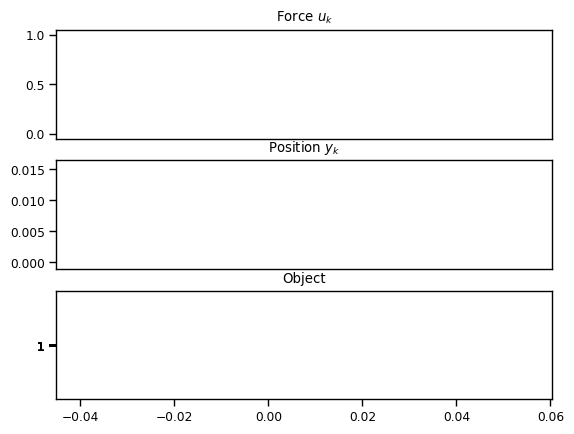

In [11]:
# Example Run
from functools import partial
def example_mass(k, b, m):
    A = torch.tensor([[0, 1], [-k / m, -b / m]], dtype=torch.float32)
    B = torch.tensor([[0], [1.0 / m]], dtype=torch.float32)
    C = torch.tensor([[1.0, 0]], dtype=torch.float32)
    return A, B, C

@partial(np.vectorize, signature="()->()")
def example_force(t):
    x = np.sin(10 * t)
    return torch.tensor(x * (x > 0.5), dtype=torch.float32)

def example_ssm():
    # SSM
    # A_n, B_n, C_n = example_mass(k=40, b=5, m=1)
    # ssm = SSM(A=A_n, B=B_n, C=C_n)
    ssm = example_mass(k=40, b=5, m=1)
    for i, val in enumerate(ssm):
        print(f"{i} -> {val}")
    state = SSM(*ssm)
    # L samples of u(t).
    L = 100
    step = 1.0 / L
    ks = np.arange(L)
    u = example_force(ks * step)

    # Approximation of y(t).
    y = state.run_SSM(*ssm, u)

    # Plotting ---
    import matplotlib.pyplot as plt
    import seaborn
    from celluloid import Camera

    seaborn.set_context("paper")
    fig, (ax1, ax2, ax3) = plt.subplots(3)
    camera = Camera(fig)
    ax1.set_title("Force $u_k$")
    ax2.set_title("Position $y_k$")
    ax3.set_title("Object")
    ax1.set_xticks([], [])
    ax2.set_xticks([], [])

    # Animate plot over time
    for k in range(0, L, 2):
        ax1.plot(ks[:k], u[:k], color="red")
        ax2.plot(ks[:k], y[:k], color="blue")
        ax3.boxplot(
            [[y[k, 0] - 0.04, y[k, 0], y[k, 0] + 0.04]],
            showcaps=False,
            whis=False,
            vert=False,
            widths=10,
        )
        camera.snap()
    anim = camera.animate()
    anim.save("images/line_ssm.gif", dpi=150, writer="imagemagick")
example_ssm()

In [20]:
u = torch.from_numpy(np.eye(3, 3))
type(u)

torch.Tensor

In [ ]:
# Random test
def discretize(A, B, C, step):
    I = torch.eye(A.shape[0])
    BL = torch.linalg.inv(I - (step / 2.0) * A)
    BL2 = (I + (step / 2) * A)
    Ab = BL @ BL2
    Bb = (BL * step) @ B
    return Ab, Bb, C

def scan_SSM(Ab, Bb, Cb, u, x0):
    try :
        if isinstance(Ab, np.ndarray):
            Ab = torch.tensor(Ab, dtype=torch.float32)
        if isinstance(Bb, np.ndarray):
            Bb = torch.tensor(Bb, dtype=torch.float32)
        if isinstance(Cb, np.ndarray):
            Cb = torch.tensor(Cb, dtype=torch.float32)
        if isinstance(u, np.ndarray):
            u = torch.tensor(u, dtype=torch.float32)
        if isinstance(x0, np.ndarray):
            x0 = torch.tensor(x0, dtype=torch.float32)
        def step(x_k_1, u_k):
            x_k = Ab @ x_k_1 + Bb @ u_k
            y_k = Cb @ x_k
            return x_k, y_k

        return torch_scan(step, x0, u)
    except Exception as e:
        print(f'{e}')

def run_SSM(A, B, C, u):
    L = u.shape[0]
    N = A.shape[0]
    Ab, Bb, Cb = discretize(A, B, C, step=1.0 / L)

    # Run recurrence
    return scan_SSM(Ab, Bb, Cb, u[:, np.newaxis], np.zeros((N,)))[1]


def example_mass(k, b, m):
    A = torch.tensor([[0, 1], [-k / m, -b / m]], dtype=torch.float32)
    B = torch.tensor([[0], [1.0 / m]], dtype=torch.float32)
    C = torch.tensor([[1.0, 0]], dtype=torch.float32)
    return A, B, C

def example_force(t):
    x = np.sin(10 * t)
    return torch.tensor(x * (x > 0.5), dtype=torch.float32)

def example_ssm():
    # SSM
    ssm = example_mass(k=40, b=5, m=1)

    # L samples of u(t).
    L = 100
    step = 1.0 / L
    ks = np.arange(L)
    u = example_force(ks * step)

    # Approximation of y(t).
    y = run_SSM(*ssm, u)

    # Plotting ---
    import matplotlib.pyplot as plt
    import seaborn
    from celluloid import Camera

    seaborn.set_context("paper")
    fig, (ax1, ax2, ax3) = plt.subplots(3)
    camera = Camera(fig)
    ax1.set_title("Force $u_k$")
    ax2.set_title("Position $y_k$")
    ax3.set_title("Object")
    ax1.set_xticks([], [])
    ax2.set_xticks([], [])

    # Animate plot over time
    for k in range(0, L, 2):
        ax1.plot(ks[:k], u[:k], color="red")
        ax2.plot(ks[:k], y[:k], color="blue")
        ax3.boxplot(
            [[y[k, 0] - 0.04, y[k, 0], y[k, 0] + 0.04]],
            showcaps=False,
            whis=False,
            vert=False,
            widths=10,
        )
        camera.snap()
    anim = camera.animate()
    anim.save("images/line.gif", dpi=150, writer="imagemagick")

example_ssm()

![Line Animation](images/line.gif)

0 -> tensor([[  0.,   1.],
        [-40.,  -5.]])
1 -> tensor([[0.],
        [1.]])
2 -> tensor([[1., 0.]])


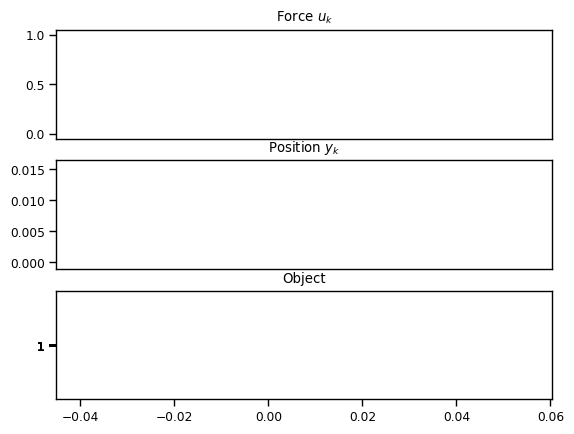

In [26]:
# Example Run
from functools import partial
def example_mass(k, b, m):
    A = torch.tensor([[0, 1], [-k / m, -b / m]], dtype=torch.float32)
    B = torch.tensor([[0], [1.0 / m]], dtype=torch.float32)
    C = torch.tensor([[1.0, 0]], dtype=torch.float32)
    return A, B, C

@partial(np.vectorize, signature="()->()")
def example_force(t):
    x = np.sin(10 * t)
    return torch.tensor(x * (x > 0.5), dtype=torch.float32)

def example_ssm():
    # SSM
    # A_n, B_n, C_n = example_mass(k=40, b=5, m=1)
    # ssm = SSM(A=A_n, B=B_n, C=C_n)
    ssm = example_mass(k=40, b=5, m=1)
    for i, val in enumerate(ssm):
        print(f"{i} -> {val}")
    state = SSM(*ssm)
    # L samples of u(t).
    L = 100
    step = 1.0 / L
    ks = np.arange(L)
    u = example_force(ks * step)

    # Approximation of y(t).
    y = state.run_SSM(*ssm, u)

    # Plotting ---
    import matplotlib.pyplot as plt
    import seaborn
    from celluloid import Camera

    seaborn.set_context("paper")
    fig, (ax1, ax2, ax3) = plt.subplots(3)
    camera = Camera(fig)
    ax1.set_title("Force $u_k$")
    ax2.set_title("Position $y_k$")
    ax3.set_title("Object")
    ax1.set_xticks([], [])
    ax2.set_xticks([], [])

    # Animate plot over time
    for k in range(0, L, 2):
        ax1.plot(ks[:k], u[:k], color="red")
        ax2.plot(ks[:k], y[:k], color="blue")
        ax3.boxplot(
            [[y[k, 0] - 0.04, y[k, 0], y[k, 0] + 0.04]],
            showcaps=False,
            whis=False,
            vert=False,
            widths=10,
        )
        camera.snap()
    anim = camera.animate()
    anim.save("images/line_ssm.gif", dpi=150, writer="imagemagick")
example_ssm()